# FuseNet: Self-Supervised Dual-Path Network for Medical Image Segmentation <br>

In [3]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as T

import cv2
import sys
import os
import numpy as np
import random
import glob
from matplotlib import pyplot as plt

from utils import read_image, dice_metric, xor_metric, hm_metric, create_mask, cross_entropy
from model_utils import Encoder, ProjectionHead, MixFFN_skip, CrossAttentionBlock

from einops import rearrange
from einops.layers.torch import Rearrange

In [4]:
use_cuda = torch.cuda.is_available()

parser = argparse.ArgumentParser(description='FuseNet: Self-Supervised Dual-Path Network for Medical Image Segmentation')
parser.add_argument('--nChannel', metavar='N', default=64, type=int, 
                    help='number of channels')
parser.add_argument('--maxIter', metavar='T', default=50, type=int, 
                    help='number of maximum iterations')
parser.add_argument('--minLabels', metavar='minL', default=3, type=int, 
                    help='minimum number of labels')
parser.add_argument('--lr', metavar='LR', default=0.005, type=float, 
                    help='learning rate')

parser.add_argument('--input_path', metavar='INPUT', default='./input_images/', 
                    help='input image folder path')
parser.add_argument('--save_output', metavar='SAVE', default=True, 
                    help='whether to save output ot not')
parser.add_argument('--output_path', metavar='OUTPUT', default='./output/', 
                    help='output folder path')

parser.add_argument('--loss_ce_coef', metavar='CE', default=2.5, type=float, 
                    help='Cross entropy loss weighting factor')
parser.add_argument('--loss_clip_coef', metavar='AT', default=0.5, type=float, 
                    help='Clip loss weighting factor')
parser.add_argument('--loss_b_coef', metavar='Spatial', default=0.5, type=float, 
                    help='Boundary loss weighting factor')

args = parser.parse_args(args=[])

In [5]:
if args.save_output:
    SAVE_PATH = args.output_path
    os.makedirs(SAVE_PATH, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading Data

In [11]:
IMG_PATH = args.input_path
img_data = sorted(glob.glob(IMG_PATH + 'image/*'))
lbl_data = sorted(glob.glob(IMG_PATH + 'GT/*'))

In [12]:
len(img_data), len(lbl_data)

(3, 4)

# Model

In [8]:
class Model(nn.Module):
    """
    Args:
        input_dim (int): Dimension of the input data.
        image_embed (int): Dimension of the image embeddings.
        augmented_embed (int): Dimension of the augmented image embeddings.
        input_size (tuple): Tuple representing the input size of the images (height, width).
        temperature (float): Temperature parameter to scale CLIP matrix.
        dropout (float): Dropout rate applied in the projection heads.
        beta (int): Downsampling factor.
        alpha (int): Scaling factor applied to the main path in the cross-attention block.
    """
    def __init__(self, input_dim, image_embed, augmented_embed, input_size=(256, 256),
                 temperature=5.0, dropout=0.1, beta=16, alpha=3):
        super(Model, self).__init__()
        
        input_H, input_W = input_size
        self.H = input_H
        
        self.beta = 16  # Downsampling factor
        self.alpha = 3  # Main path scaling factor
        self.img_enc = Encoder(input_dim, image_embed)
        self.aug_enc = Encoder(input_dim, image_embed)
        
        self.image_projection = ProjectionHead(embedding_dim=image_embed, projection_dim=image_embed, dropout=dropout)
        self.aug_projection = ProjectionHead(embedding_dim=augmented_embed, projection_dim=augmented_embed, dropout=dropout)
        self.temperature = temperature
        
        self.cross_attn = CrossAttentionBlock(in_channels=image_embed, key_channels=image_embed,
                                              value_channels=image_embed, height=input_H, width=input_W)
        
        
        self.patch_size = self.H//8 #32
        self.dim = image_embed
        patch_dim = self.dim * self.patch_size * self.patch_size
        
        self.to_patch_embedding_img = nn.Sequential(
            Rearrange('b (h p1) (w p2) c -> b (h w) (p1 p2 c)', p1 = self.patch_size, p2 = self.patch_size),
            nn.Linear(patch_dim, self.dim))
        
        self.to_patch_embedding_aug = nn.Sequential(
            Rearrange('b (h p1) (w p2) c -> b (h w) (p1 p2 c)', p1 = self.patch_size, p2 = self.patch_size),
            nn.Linear(patch_dim, self.dim))    
        
        self.bn1 = nn.BatchNorm2d(image_embed)
        self.bn2 = nn.BatchNorm2d(image_embed)
        
        
    def forward(self, x, augmented_x):

        # extract feature representations of each modality
        img_f = self.img_enc(x)
        aug_f = self.img_enc(augmented_x) 

        img_f = rearrange(img_f, 'b c h w -> b (h w) c')
        aug_f = rearrange(aug_f, 'b c h w -> b (h w) c')

        # Getting Image and augmented image Embeddings (with same dimension)
        img_e = self.image_projection(img_f)
        aug_e = self.aug_projection(aug_f)
                
        # Calculating CLIP
        img_e_r = self.bn1(rearrange(img_e, 'b (h w) c -> b c h w', h=self.H)).permute(0, 2, 3, 1)
        aug_e_r = self.bn2(rearrange(aug_e, 'b (h w) c -> b c h w', h=self.H)).permute(0, 2, 3, 1)
        
        img_e_patch = self.to_patch_embedding_img(img_e_r) 
        aug_e_patch = self.to_patch_embedding_aug(aug_e_r) 
        
        img_e_norm = img_e_patch / img_e_patch.norm(dim=-1, keepdim=True)        
        aug_e_norm = aug_e_patch / aug_e_patch.norm(dim=-1, keepdim=True)
        
        clip_sim = (img_e_norm @ aug_e_norm.mT) / self.temperature
        img_e_sim = img_e_norm @ img_e_norm.mT
        aug_e_sim = aug_e_norm @ aug_e_norm.mT
        clip_targets = F.softmax((img_e_sim + aug_e_sim) / 2 * self.temperature, dim=-1)
        
        # Cross attention
        attn_1 = self.cross_attn(img_e*self.alpha, aug_e*0.8)
        attn_2 = self.cross_attn(aug_e*0.8, img_e*self.alpha)
        
        attn = attn_1 + attn_2
        
        _, edge1 = torch.max(attn, 1)
        attn_down = torchvision.transforms.functional.resize(attn, 256//self.beta, antialias=True)
        attn_up = torchvision.transforms.functional.resize(attn_down, 256, antialias=True)
        _, edge2 = torch.max(attn_up, 1)
        edge = edge1 - edge2

        return edge, attn, clip_sim, clip_targets


# Training

In [9]:
img_size = 256

0 / 50 |  label num: 37  | loss: 12.4755 | CE: 2.1217 | CLIP: 2.0835 | B: 8.2703
1 / 50 |  label num: 27  | loss: 6.0058 | CE: 0.3809 | CLIP: 2.0478 | B: 3.5772
2 / 50 |  label num: 18  | loss: 4.1207 | CE: 0.1755 | CLIP: 2.0245 | B: 1.9208
3 / 50 |  label num: 12  | loss: 3.4541 | CE: 0.0971 | CLIP: 2.0205 | B: 1.3365
4 / 50 |  label num: 8  | loss: 3.1565 | CE: 0.0615 | CLIP: 2.0157 | B: 1.0793
5 / 50 |  label num: 7  | loss: 3.091 | CE: 0.0493 | CLIP: 2.0104 | B: 1.0314
6 / 50 |  label num: 6  | loss: 3.0133 | CE: 0.0384 | CLIP: 2.0053 | B: 0.9696
7 / 50 |  label num: 6  | loss: 2.9986 | CE: 0.0343 | CLIP: 2.0023 | B: 0.962
8 / 50 |  label num: 4  | loss: 2.9775 | CE: 0.0288 | CLIP: 2.0009 | B: 0.9479
9 / 50 |  label num: 4  | loss: 2.9529 | CE: 0.0242 | CLIP: 2.0008 | B: 0.9278
10 / 50 |  label num: 4  | loss: 2.946 | CE: 0.0214 | CLIP: 2.0011 | B: 0.9235
11 / 50 |  label num: 3  | loss: 2.9283 | CE: 0.018 | CLIP: 2.0009 | B: 0.9094
Number of labels have reached 3


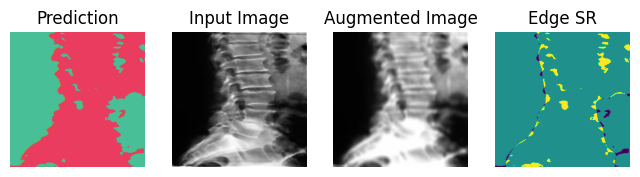

------------------------------- 

0 / 50 |  label num: 67  | loss: 19.0075 | CE: 2.5439 | CLIP: 2.0825 | B: 14.3812
1 / 50 |  label num: 47  | loss: 13.0631 | CE: 0.8993 | CLIP: 2.0462 | B: 10.1176
2 / 50 |  label num: 42  | loss: 10.5078 | CE: 0.4466 | CLIP: 2.0301 | B: 8.0311
3 / 50 |  label num: 31  | loss: 7.5451 | CE: 0.2584 | CLIP: 2.0245 | B: 5.2622
4 / 50 |  label num: 21  | loss: 6.4119 | CE: 0.1688 | CLIP: 2.0178 | B: 4.2252
5 / 50 |  label num: 18  | loss: 6.0436 | CE: 0.1354 | CLIP: 2.0118 | B: 3.8964
6 / 50 |  label num: 13  | loss: 5.8958 | CE: 0.1138 | CLIP: 2.0069 | B: 3.775
7 / 50 |  label num: 11  | loss: 5.8719 | CE: 0.1053 | CLIP: 2.004 | B: 3.7626
8 / 50 |  label num: 10  | loss: 5.8617 | CE: 0.0978 | CLIP: 2.0021 | B: 3.7618
9 / 50 |  label num: 8  | loss: 5.7172 | CE: 0.0873 | CLIP: 2.0008 | B: 3.629
10 / 50 |  label num: 7  | loss: 5.6814 | CE: 0.0773 | CLIP: 2.0 | B: 3.604
11 / 50 |  label num: 4  | loss: 5.6393 | CE: 0.0725 | CLIP: 1.9996 | B: 3.5672
12 / 50 |

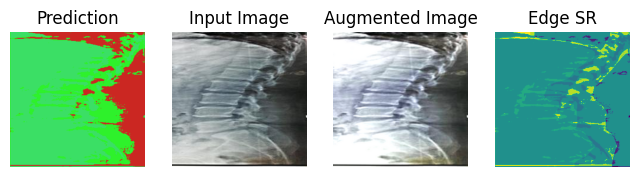

------------------------------- 

0 / 50 |  label num: 49  | loss: 11.8765 | CE: 2.629 | CLIP: 2.0854 | B: 7.1621
1 / 50 |  label num: 40  | loss: 6.6649 | CE: 1.4619 | CLIP: 2.0617 | B: 3.1413
2 / 50 |  label num: 22  | loss: 4.0206 | CE: 0.2189 | CLIP: 2.0203 | B: 1.7814
3 / 50 |  label num: 19  | loss: 3.5186 | CE: 0.0815 | CLIP: 2.017 | B: 1.4202
4 / 50 |  label num: 15  | loss: 3.444 | CE: 0.0366 | CLIP: 2.0156 | B: 1.3919
5 / 50 |  label num: 12  | loss: 3.4402 | CE: 0.031 | CLIP: 2.0124 | B: 1.3968
6 / 50 |  label num: 10  | loss: 3.4267 | CE: 0.0268 | CLIP: 2.0088 | B: 1.3911
7 / 50 |  label num: 7  | loss: 3.394 | CE: 0.0223 | CLIP: 2.0053 | B: 1.3665
8 / 50 |  label num: 6  | loss: 3.4007 | CE: 0.0197 | CLIP: 2.0029 | B: 1.378
9 / 50 |  label num: 6  | loss: 3.3931 | CE: 0.0172 | CLIP: 2.0011 | B: 1.3748
10 / 50 |  label num: 5  | loss: 3.3912 | CE: 0.0146 | CLIP: 1.9999 | B: 1.3768
11 / 50 |  label num: 4  | loss: 3.4005 | CE: 0.0141 | CLIP: 1.9988 | B: 1.3877
12 / 50 |  lab

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


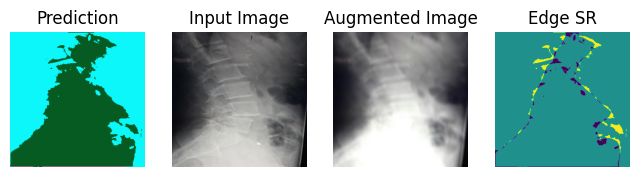

------------------------------- 



In [13]:
for img_num, img_file in enumerate(img_data):
    
    ##### Read image #####
    image = read_image(img_file, img_size).to(device)

    ##### Laod Model #####
    model = Model(input_dim=3, image_embed=64, augmented_embed=64,
                  input_size=(img_size, img_size), temperature=5.0, dropout=0.1,
                  beta=16, alpha=3).to(device)
    model.train()

    ##### Setteings #####
    zero_img = torch.zeros(image.shape[2], image.shape[3]).to(device)
    
    loss_ce = torch.nn.CrossEntropyLoss()
    loss_s = torch.nn.L1Loss()
    
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=0.9)
    label_colours = np.random.randint(255, size=(128, 3))
    
    
    jitter = T.ColorJitter(brightness=[1.4, 1.4], hue=[-0.06, -0.06])
    aug_img = jitter(image)
    aug_img = T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))(aug_img)
    aug_img = aug_img.to(device)
    
    ##### Training #####
    for batch_idx in range(args.maxIter):

        optimizer.zero_grad()
        edge, output, clip_logits, clip_targets = model(image, aug_img)
        
        ### Output
        output, clip_logits, clip_targets = output[0], clip_logits[0], clip_targets[0]        
        output = output.permute(1, 2, 0).contiguous().view(-1, args.nChannel*2)
                
        _, target = torch.max(output, 1)
        img_target = target.data.cpu().numpy()
        img_target_rgb = np.array([label_colours[c % args.nChannel] for c in img_target])
        img_target_rgb = img_target_rgb.reshape(image.shape[2], image.shape[3], image.shape[1]).astype(np.uint8)
        
        ### Cross-entropy loss function         
        loss_ce_value = args.loss_ce_coef * loss_ce(output, target)
        
        ### Boundary Loss
        loss_edge = args.loss_b_coef * loss_s(edge[0], zero_img)  
        
        ### CLIP loss 
        aug_loss = cross_entropy(clip_logits, clip_targets, 'mean')
        img_loss = cross_entropy(clip_logits.T, clip_targets.T, 'mean')
        loss_clip = args.loss_clip_coef * ((img_loss + aug_loss) / 2.0)
        
        ### Optimization        
        loss = loss_ce_value + loss_clip + loss_edge
        loss.backward()
        optimizer.step()
        
        
        nLabels = len(np.unique(img_target))
        print(batch_idx, '/', args.maxIter, '|', ' label num:', nLabels, ' | loss:', round(loss.item(), 4),
                '| CE:', round(loss_ce_value.item(), 4), '| CLIP:', round(loss_clip.item(), 4),
                '| B:', round(loss_edge.item(), 4))
            
        if nLabels <= args.minLabels and batch_idx>=5:
            print (f"Number of labels have reached {nLabels}")
            break
        

    ##### Evaluate #####
    edge, output, _, _ = model(image, aug_img)
    output = output[0].permute(1, 2, 0).contiguous().view(-1, args.nChannel*2)
    _, target = torch.max(output, 1)
    img_target = target.data.cpu().numpy()
    img_eval_output = np.array([label_colours[c % args.nChannel] for c in img_target])
    img_eval_output = img_eval_output.reshape(image.shape[2], image.shape[3], image.shape[1]).astype(np.uint8)
    
    
    ##### Visualization #####
    fig, axes = plt.subplots(1, 4, figsize=(8, 8))
    axes[0].imshow(img_eval_output)
    axes[1].imshow(image[0].permute(1, 2, 0).cpu().detach().numpy()[..., ::-1])
    axes[2].imshow(aug_img[0].permute(1, 2, 0).cpu().detach().numpy()[...,::-1])
    axes[3].imshow(edge[0].cpu().detach().numpy())
    axes[0].set_title('Prediction')
    axes[1].set_title('Input Image')
    axes[2].set_title('Augmented Image')
    axes[3].set_title('Edge SR')    
    axes[0].axis('off')
    axes[1].axis('off')
    axes[2].axis('off')
    axes[3].axis('off')
    plt.show()
    
    if args.save_output:
        name = os.path.basename(img_file).split('.')[0]
        cv2.imwrite(SAVE_PATH + '/FuseNet_mask_' + name + '.png', img_eval_output)
        cv2.imwrite(SAVE_PATH + '/FuseNet_img_' + name + '.png', image[0].permute(1, 2, 0).cpu().detach().numpy()*255)
        cv2.imwrite(SAVE_PATH + '/FuseNet_aug_' + name + '.png', aug_img[0].permute(1, 2, 0).cpu().detach().numpy()*255)
        
    print('-------------------------------', '\n')